In [1]:
import os
import warnings
import pandas as pd
import numpy as np
from datetime import datetime

import numpy as np
import pywt
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, make_scorer


from pyts.classification import TimeSeriesForest
from pyts.multivariate.classification import MultivariateClassifier
from sklearn.model_selection import train_test_split
import random


from sklearn.model_selection import GridSearchCV


warnings.filterwarnings("ignore")

In [2]:
# Specify the directory path
folder_dir = 'partition1/FL'
files = os.listdir(folder_dir)
print("Number of files in FL:",len(files))

fl_X_data = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)


    fl_X_data.append(df_interpolated.values)

fl_y_data = np.array(['FL']*len(fl_X_data))
fl_X_data = np.array(fl_X_data)

fl_X_data.shape, fl_y_data.shape

Number of files in FL: 1254


((1254, 60, 5), (1254,))

In [3]:
# Specify the directory path
folder_dir = 'partition1/NF'
files = os.listdir(folder_dir)
print("Number of files in NF:",len(files))

nf_X_data = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)


    nf_X_data.append(df_interpolated.values)

nf_y_data = np.array(['NF']*len(nf_X_data))
nf_X_data = np.array(nf_X_data)

nf_X_data.shape, nf_y_data.shape

Number of files in NF: 72238


((72238, 60, 5), (72238,))

## multivariate modelling - all partition1 data

### class imbalance and train test split

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Combine the training sets
X_train_combined = np.concatenate((fl_X_data, nf_X_data), axis=0)
y_train_combined = np.concatenate((fl_y_data, nf_y_data))

print(f"\nX Train shape: {X_train_combined.shape}")
print(f"y Train shape: {y_train_combined.shape}")


X Train shape: (73492, 60, 5)
y Train shape: (73492,)


In [ ]:
from pyts.classification import TimeSeriesForest
from pyts.multivariate.classification import MultivariateClassifier

clf = MultivariateClassifier(TimeSeriesForest())
clf.fit(X_train_combined, y_train_combined)

In [11]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

y_pred = clf.predict(X_test_combined)
print(classification_report(y_pred, y_test_combined))
#print(f1_score(y_pred, y_test_combined))
print(accuracy_score(y_pred, y_test_combined))

              precision    recall  f1-score   support

          FL       0.40      0.97      0.56       155
          NF       1.00      0.99      0.99     21894

    accuracy                           0.99     22049
   macro avg       0.70      0.98      0.78     22049
weighted avg       1.00      0.99      0.99     22049

0.9894779808608101


In [9]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_combined, y_pred)
TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

# Calculate True Skill Statistic (TSS)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
TSS = sensitivity + specificity - 1

# Calculate Heidke Skill Score (HSS)
HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

print(f"True Skill Statistic (TSS): {TSS}")
print(f"Heidke Skill Score (HSS): {HSS}")

True Skill Statistic (TSS): 0.3976472716448658
Heidke Skill Score (HSS): 0.5595211585990353


## multivariate modelling - sample of data

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import random

indices_true_train, indices_true_test = train_test_split(
    np.arange(len(fl_X_data)),
    test_size=0.3,
    random_state=42
)

X_true_train = fl_X_data[indices_true_train]
X_true_test = fl_X_data[indices_true_test]
y_true_train = fl_y_data[indices_true_train]
y_true_test = fl_y_data[indices_true_test]

print("FL data points:",X_true_train.shape, X_true_test.shape, y_true_train.shape, y_true_test.shape)

# Subsample false class data to match the size of true class data
random_indices = random.sample(range(len(nf_X_data)), 1500)

false_class_data_subsampled = np.array([nf_X_data[i] for i in random_indices])
nf_y_subsampled = [nf_y_data[i] for i in random_indices]

# Split false class data into training and testing sets
indices_false_train, indices_false_test = train_test_split(
    np.arange(len(false_class_data_subsampled)),
    test_size=0.3,
    random_state=42
)

X_false_train = false_class_data_subsampled[indices_false_train]
X_false_test = false_class_data_subsampled[indices_false_test]
y_false_train = np.array(['NF']*len(indices_false_train))
y_false_test = np.array(['NF']*len(indices_false_test))

print("NF data points:",X_false_train.shape, X_false_test.shape, y_false_train.shape, y_false_test.shape)

# Combine the training sets
X_train_combined = np.concatenate((X_true_train, X_false_train), axis=0)
y_train_combined = np.concatenate((y_true_train, y_false_train))
# Combine the testing sets
X_test_combined = np.concatenate((X_true_test, X_false_test), axis=0)
y_test_combined = np.concatenate((y_true_test, y_false_test))

print(f"\nX Train shape: {X_train_combined.shape} and test shape: {X_test_combined.shape}")
print(f"y Train shape: {y_train_combined.shape} and test shape: {y_test_combined.shape}")

FL data points: (877, 60, 5) (377, 60, 5) (877,) (377,)
NF data points: (1050, 60, 5) (450, 60, 5) (1050,) (450,)

X Train shape: (1927, 60, 5) and test shape: (827, 60, 5)
y Train shape: (1927,) and test shape: (827,)


In [16]:
nf_random_indices = random.sample(range(len(nf_X_data)), 1254)

nf_random_X_data_subsampled = np.array([nf_X_data[i] for i in nf_random_indices])
nf_y_subsampled = np.array(["NF"]*len(nf_random_X_data_subsampled))

# combina fl and nf data sets
X_combined = np.concatenate((fl_X_data, nf_random_X_data_subsampled), axis=0)
y_combined = np.concatenate((fl_y_data, nf_y_subsampled))

print(X_combined.shape, y_combined.shape)

(2508, 60, 5) (2508,)


## Grid search CV

## custom scoring

In [17]:
def generating_scores(y_test, y_pred):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

    # Calculate Heidke Skill Score (HSS)
    HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

    # Calculate True Skill Statistic (TSS)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    TSS = sensitivity + specificity - 1

    return conf_matrix, HSS, TSS

In [21]:
def custom_scoring_function(y_true, y_pred):

    conf_matrix = confusion_matrix(y_true, y_pred)
    TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]
    HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

    return HSS

# Make a scorer using the custom scoring function
custom_scorer_hss = make_scorer(custom_scoring_function)

In [26]:
# Specify the classifier and its parameters
base_classifier = TimeSeriesForest()
classifier = MultivariateClassifier(base_classifier)

# Define the parameter grid for GridSearchCV

param_grid = {
'estimator__n_windows' : [5,10,15,20,25,30,35,40,45,50,55,60],
'estimator__min_window_size' : [1,2,3],
'estimator__max_depth' : [None, 3,5],
'estimator__n_estimators': [150]
}

grid_search = GridSearchCV(classifier, param_grid, scoring=custom_scorer_hss, cv=3)

grid_search.fit(X_combined, y_combined)

print("Best parameters found: ", grid_search.best_params_)
print(f"Best HSS score: {grid_search.best_score_}")

Best parameters found:  {'estimator__max_depth': None, 'estimator__min_window_size': 1, 'estimator__n_estimators': 600, 'estimator__n_windows': 60}
Best HSS score: 0.8556618819776715


In [ ]:
Best parameters found:  {'estimator__max_depth': None, 'estimator__min_window_size': 1, 'estimator__n_estimators': 600, 'estimator__n_windows': 60}
Best HSS score: 0.8564593301435407

In [27]:
#train the model
clf = MultivariateClassifier(TimeSeriesForest(max_depth=None, min_window_size=1, n_windows = 60, n_estimators=600, random_state=25))
clf.fit(X_combined, y_combined)

MultivariateClassifier(estimator=TimeSeriesForest(n_estimators=600,
                                                  n_windows=60,
                                                  random_state=25))

## test on other partitions

In [51]:
# Specify the directory path

partition = "partition4"

folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/FL'
files = os.listdir(folder_dir)
print("Number of files in FL:",len(files))

fl_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)


    fl_X_data_part2.append(df_interpolated.values)

fl_y_data_part2 = np.array(['FL']*len(fl_X_data_part2))
fl_X_data_part2 = np.array(fl_X_data_part2)

print(fl_X_data_part2.shape, fl_y_data_part2.shape)

# Specify the directory path
folder_dir = f'/Users/Manya/Desktop/GRA DMLab/SWAN-SF dataset/{partition}/NF'
files = os.listdir(folder_dir)
print("Number of files in NF:",len(files))

nf_X_data_part2 = []

for file in files:
    df_tmp = pd.read_csv(folder_dir + "/" + file, sep='\\t')
    df_tmp = df_tmp[['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH']]

    # interpolation
    array = df_tmp.to_numpy()
    interpolated_array = np.apply_along_axis(
        lambda column: np.interp(np.arange(len(column)), np.where(~np.isnan(column))[0], column[~np.isnan(column)]),
        axis=0,
        arr=array
    )
    df_interpolated = pd.DataFrame(interpolated_array, columns=df_tmp.columns)

    nf_X_data_part2.append(df_interpolated.values)

nf_y_data_part2 = np.array(['NF']*len(nf_X_data_part2))
nf_X_data_part2 = np.array(nf_X_data_part2)

nf_X_data_part2.shape, nf_y_data_part2.shape

Number of files in FL: 1165
(1165, 60, 5) (1165,)
Number of files in NF: 50096


((50096, 60, 5), (50096,))

In [52]:
nf_random_indices_part2 = random.sample(range(len(nf_X_data_part2)), 1165)

nf_random_X_data_subsampled_part2 = np.array([nf_X_data_part2[i] for i in nf_random_indices_part2])
nf_y_subsampled_part2 = np.array(["NF"]*len(nf_random_X_data_subsampled_part2))

# combine fl and nf data sets
X_combined_part2 = np.concatenate((fl_X_data_part2, nf_random_X_data_subsampled_part2), axis=0)
y_combined_part2 = np.concatenate((fl_y_data_part2, nf_y_subsampled_part2))

print(X_combined_part2.shape, y_combined_part2.shape)

(2330, 60, 5) (2330,)


HSS:  0.7184549356223175
TSS:  0.7184549356223178


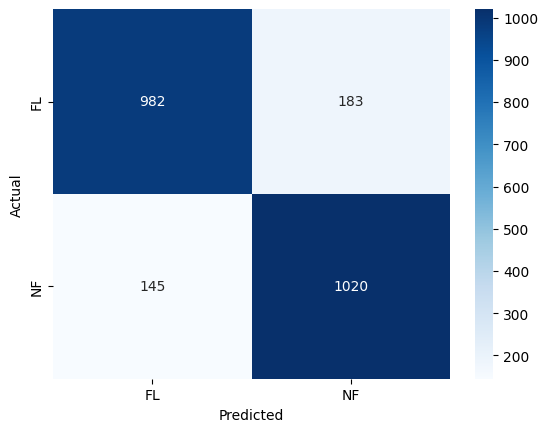

In [53]:
y_pred = clf.predict(X_combined_part2)
conf_matrix, hss_score, tss_score = generating_scores(y_combined_part2, y_pred)
hss_score, tss_score

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['FL', 'NF'],
            yticklabels=['FL', 'NF'])

print("HSS: ", hss_score)
print("TSS: ", tss_score)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

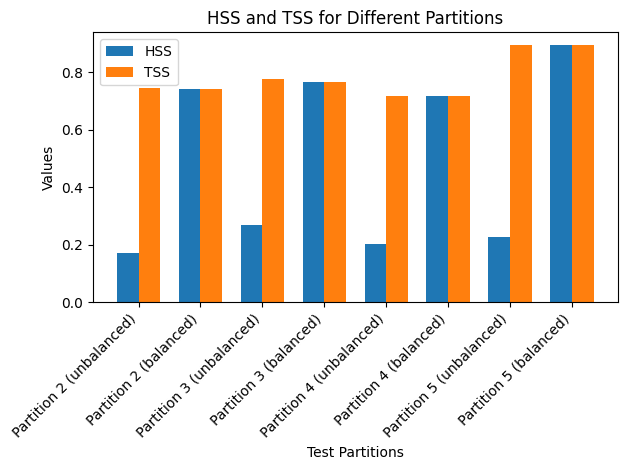

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset
partitions = ['Partition 2 (unbalanced)', 'Partition 2 (balanced)', 'Partition 3 (unbalanced)', 'Partition 3 (balanced)',
              'Partition 4 (unbalanced)', 'Partition 4 (balanced)', 'Partition 5 (unbalanced)', 'Partition 5 (balanced)']

hss_values = [0.1727, 0.74, 0.2672, 0.764, 0.2034, 0.7184, 0.2284, 0.8929]
tss_values = [0.7439, 0.7399, 0.7777, 0.764, 0.7186, 0.7184, 0.8937, 0.8929]

# Bar graph
bar_width = 0.35
index = np.arange(len(partitions))

fig, ax = plt.subplots()
bar1 = ax.bar(index, hss_values, bar_width, label='HSS')
bar2 = ax.bar(index + bar_width, tss_values, bar_width, label='TSS')

ax.set_xlabel('Test Partitions')
ax.set_ylabel('Values')
ax.set_title('HSS and TSS for Different Partitions')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(partitions, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()